In [ ]:
%%capture
import numpy as np
# import pandas as pd
import torch, os

# download the code written for the project
if not os.path.isdir('/content/spectral-topology'):
  !git clone https://github.com/sarinstein-yan/spectral-topology.git
  %cd ./spectral-topology

# download the datasets
!pip3 install -U gdown
import gdown
# dataset_url = 'https://drive.google.com/drive/folders/15sMx2pHBplGxy6KpvtkW0NXLNUgee1-s?usp=sharing'
# gdown.download_folder(dataset_url, resume=True)#, skip_download=True)
dataset_url = 'https://drive.google.com/drive/folders/1cOXWp3NhUU1pBDnp7d3mkMDYy9dxbINi?usp=sharing'
gdown.download_folder(dataset_url, resume=True)#, skip_download=True)

# other imports
# os.environ['TORCH'] = torch.__version__; print(torch.__version__)
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torchmetrics
!pip install pytorch-ignite

import matplotlib.pyplot as plt
plt.style.use('bmh')
import plotly.graph_objects as go
# !pip install torchviz
# !pip install pyvis
# !pip install umap-learn

from spectra_topology_utils import *
from dataset_generation import generate_dataset_graph, load_dataset_graph, auto_Emax
import itertools, h5py, pickle
# import os, sys, time, re, glob, json, argparse, logging, warnings

# Morphological Graph Topology of non-Hermitian Spectra
(dated: 23 AUG 2024)

## 1. Dataset

In [ ]:
import ipywidgets as wgt

def plot_phi(plot_type, overlay_graph, c_left, c0, c1, c2, c_m, c3, c4, c5, c_right):#, Emax):
    c = np.array([c_left, c0, c1, c2, c_m, c3, c4, c5, c_right])
    Emax = auto_Emax(c, emax=20, elen=64)
    if plot_type == 'potential':
        if overlay_graph: raise NotImplementedError
        img = Phi_image(c, Emax=Emax, Elen=200)
    if plot_type == 'DOS':
        img = PosLoG(Phi_image(c, Emax=Emax, Elen=200))
    if plot_type == 'binarized':
        img = binarized_Phi_image(c, Emax=Emax, Elen=300)
    draw_image(img, overlay_graph=overlay_graph)
    plt.show()

c_rightange_max = 1.2
wgt.interactive(plot_phi,
plot_type=wgt.ToggleButtons(options=['potential', 'DOS', 'binarized'], value='DOS'),
overlay_graph=wgt.Checkbox(value=False),
c_left=wgt.IntSlider(min=0, max=1, step=1, value=1),
c0=wgt.FloatSlider(min=-c_rightange_max, max=c_rightange_max, step=2.4/6, value=1.),
c1=wgt.FloatSlider(min=-c_rightange_max, max=c_rightange_max, step=2.4/6, value=.7),
c2=wgt.FloatSlider(min=-c_rightange_max, max=c_rightange_max, step=2.4/6, value=-.5),
c_m=wgt.fixed(0),
c3=wgt.FloatSlider(min=-c_rightange_max, max=c_rightange_max, step=2.4/6, value=-.2),
c4=wgt.FloatSlider(min=-c_rightange_max, max=c_rightange_max, step=2.4/6, value=.3),
c5=wgt.FloatSlider(min=-c_rightange_max, max=c_rightange_max, step=2.4/6, value=-.5),
c_right=wgt.IntSlider(min=0, max=1, step=1, value=1))
# Emax=wgt.FloatSlider(min=1, max=12, step=1, value=5))

interactive(children=(ToggleButtons(description='plot_type', index=1, options=('potential', 'DOS', 'binarized'…

## 2. `AttentiveGnL`: a new GNN architecture for graph classification

In [ ]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Linear, GRUCell
from torch_geometric.nn import aggr, GATv2Conv, GraphConv, TransformerConv, ResGatedGraphConv, MLP
# from gnn_models import AGnLConv, AttentiveGnL
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx

class AGnLConv(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_layers: int,
        dropout: float = 0.0,
        conv_kwargs: dict = {},
    ):
        super().__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.conv1 = TransformerConv(in_channels, hidden_channels, dropout=dropout,
                                     edge_dim=-1, **conv_kwargs)
        self.gru1 = GRUCell(hidden_channels, in_channels)
        self.lin1 = Linear(in_channels, hidden_channels)

        self.convs = torch.nn.ModuleList()
        self.grus = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(TransformerConv(hidden_channels, hidden_channels, edge_dim=-1,
                                              dropout=dropout, **conv_kwargs))
            self.grus.append(GRUCell(hidden_channels, hidden_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.gru1.reset_parameters()
        self.lin1.reset_parameters()
        for conv, gru in zip(self.convs, self.grus):
            conv.reset_parameters()
            gru.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor,
                batch: Tensor) -> Tensor:
        # Atom Embedding:
        h = F.elu_(self.conv1(x, edge_index, edge_attr))
        h = F.dropout(h, p=self.dropout, training=self.training)
        x = self.gru1(h, x).relu_()
        x = F.leaky_relu_(self.lin1(x))
        g = [x]

        for conv, gru in zip(self.convs, self.grus):
            h = F.elu(conv(x, edge_index, edge_attr))
            h = F.dropout(h, p=self.dropout, training=self.training)
            x = gru(h, x).relu()
            g.append(x)

        return sum(g)   # sum hierarchical node embeddings

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}('
                f'in_channels={self.in_channels}, '
                f'hidden_channels={self.hidden_channels}, '
                f'num_layers={self.num_layers}, '
                f'dropout={self.dropout})'
                f')')

# class GnL_multiclass(torch.nn.Module): # SetTransformerAggregation
#     def __init__(self, dim_in_G, dim_in_L, dim_h_conv, dim_h_lin, dim_out,
#                  num_layers_conv, num_layer_lin, dropout=0.):
#         super().__init__()
#         # torch.manual_seed(42)
#         self.conv_G = AGnLConv(in_channels=dim_in_G,
#                                 hidden_channels=dim_h_conv,
#                                 num_layers=num_layers_conv,
#                                 dropout=dropout)
#         self.conv_L = AGnLConv(in_channels=dim_in_L,
#                                 hidden_channels=dim_h_conv,
#                                 num_layers=num_layers_conv,
#                                 dropout=dropout)

#         self.pool_G = aggr.SetTransformerAggregation(dim_h_conv)
#         self.pool_L = aggr.SetTransformerAggregation(dim_h_conv)

#         self.mlp = MLP(in_channels=dim_h_conv*2,
#                        hidden_channels=dim_h_lin,
#                        out_channels=dim_out,
#                        num_layers=num_layer_lin,
#                        dropout=dropout)

#     def forward(self, data_G, data_L):
#         x_G, edge_index_G, edge_attr_G, batch_G = data_G.x, data_G.edge_index, data_G.edge_attr, data_G.batch
#         x_L, edge_index_L, edge_attr_L, batch_L = data_L.x, data_L.edge_index, data_L.edge_attr, data_L.batch

#         x_G = self.conv_G(x_G, edge_index_G, edge_attr_G, batch_G)
#         x_L = self.conv_L(x_L, edge_index_L, edge_attr_L, batch_L)

#         x_G = self.pool_G(x_G, batch_G)
#         x_L = self.pool_L(x_L, batch_L)

#         x = torch.cat([x_G, x_L], dim=1)
#         x = self.mlp(x)
#         return F.log_softmax(x, dim=1)


class GnL_multiclass(torch.nn.Module): # Sort Pooling
    def __init__(self, dim_in_G, dim_in_L, dim_h_conv, dim_h_lin, dim_out,
                 num_layers_conv, num_layer_lin, pool_k_G, pool_k_L, dropout=0.):
        super().__init__()
        # torch.manual_seed(42)
        self.conv_G = AGnLConv(in_channels=dim_in_G,
                                hidden_channels=dim_h_conv,
                                num_layers=num_layers_conv,
                                dropout=dropout)
        self.conv_L = AGnLConv(in_channels=dim_in_L,
                                hidden_channels=dim_h_conv,
                                num_layers=num_layers_conv,
                                dropout=dropout)

        self.pool_G = aggr.SortAggregation(k=pool_k_G)
        self.pool_L = aggr.SortAggregation(k=pool_k_L)
        self.pool_k_G = pool_k_G; self.pool_k_L = pool_k_L

        self.mlp = MLP(in_channels=dim_h_conv*(pool_k_G+pool_k_L),
                       hidden_channels=dim_h_lin,
                       out_channels=dim_out,
                       num_layers=num_layer_lin,
                       dropout=dropout)

    def forward(self, data_G, data_L):
        x_G, edge_index_G, edge_attr_G, batch_G = data_G.x, data_G.edge_index, data_G.edge_attr, data_G.batch
        x_L, edge_index_L, edge_attr_L, batch_L = data_L.x, data_L.edge_index, data_L.edge_attr, data_L.batch
        x_G = self.conv_G(x_G, edge_index_G, edge_attr_G, batch_G)
        x_L = self.conv_L(x_L, edge_index_L, edge_attr_L, batch_L)

        x_G = self.pool_G(x_G, batch_G)
        x_L = self.pool_L(x_L, batch_L)

        x = torch.cat([x_G, x_L], dim=1)
        x = self.mlp(x)
        return F.log_softmax(x, dim=1)

## 3. Training and Testing

Load the dataset, and preprocess to obtain the training targets. We print some statistics to ensure the correctness of the dataset.

In [ ]:
graphs, labels = load_dataset_graph('./Datasets/dataset_graph_dim6')

labels_signs = np.where(np.abs(labels) < 1e-6, 0, 1)

hashed_labels = hash_labels(labels_signs, 2, 6)

In [ ]:
print(f'Number of graphs: {len(graphs)}')
print(f'Coefficients shape: {labels.shape}')
print(f'Multi-class targets shape: {hashed_labels.shape}')
print(f'Multi-label targets shape: {labels.shape}')
print(f'Type of graph: {type(graphs[0])}')

avg_num_nodes = np.mean([graph.number_of_nodes() for graph in graphs])
avg_num_edges = np.mean([graph.number_of_edges() for graph in graphs])
print(f"Average number of nodes: {avg_num_nodes:.2f}, Average number of edges: {avg_num_edges:.2f}")
max_num_nodes = np.max([graph.number_of_nodes() for graph in graphs])
max_num_edges = np.max([graph.number_of_edges() for graph in graphs])
print(f"Max number of nodes: {max_num_nodes}, Max number of edges: {max_num_edges}")

Number of graphs: 117649
Coefficients shape: (117649, 6)
Multi-class targets shape: (117649,)
Multi-label targets shape: (117649, 6)
Type of graph: <class 'networkx.classes.multigraph.MultiGraph'>
Average number of nodes: 9.86, Average number of edges: 10.69
Max number of nodes: 23, Max number of edges: 29


Convert `networkx.MultiGraph` to `torch_geometric.data.Data`, and pre-transform the graphs to line graphs. Shovel them into a `Dateset` object.

In [ ]:
def preprocess_networkx_graph(Phi_graph):
    Phi_graph = Phi_graph.copy()
    scale = Phi_graph.graph['Emax'] / Phi_graph.graph['Elen'] * 128

    for n in Phi_graph.nodes(data=True):
        if 'pts' in n[1]: del n[1]['pts']
        n[1]['o'] = n[1]['o'] * scale
        n[1]['o'] = n[1]['o'].astype(np.float32)

    for e in Phi_graph.edges(data=True):
        pts5_idx = np.round(np.linspace(0, len(e[2]['pts'])-1, 7)).astype(int)[1:-1]
        e[2]['pts5'] = e[2]['pts'][pts5_idx].flatten().astype(np.float32)
        pts2_idx = np.round(np.linspace(0, len(e[2]['pts'])-1, 4)).astype(int)[1:-1]
        e[2]['pts2'] = e[2]['pts'][pts2_idx].astype(np.float32)
        for key in ['pts5', 'pts2', 'weight']:
            e[2][key] = e[2][key] * scale
            e[2][key] = e[2][key].astype(np.float32)
        if 'pts' in e[2]: del e[2]['pts']

    return Phi_graph

def to_pyg_data_L(processed_G, group_node_attrs=['weight'], group_edge_attrs=['o']):
    L = LG_undirected(processed_G, triplet_feature=True)
    if L.number_of_edges() == 0:
        L = LG_undirected(processed_G, selfloops=True, triplet_feature=True)
    G = from_networkx(L, group_node_attrs=group_node_attrs, group_edge_attrs=group_edge_attrs)
    return G


# processed_Gs = [preprocess_networkx_graph(graph) for graph in graphs]
# pyg_data_G_list = [from_networkx(g, group_node_attrs=['o'], group_edge_attrs=['weight', 'pts5']) for g in processed_Gs]
# pyg_data_L_list = [to_pyg_data_L(g, group_node_attrs=['weight', 'pts5'], group_edge_attrs=['angle']) for g in processed_Gs]

# for i, pyg_data in enumerate(pyg_data_G_list):
#     pyg_data.y = torch.tensor([hashed_labels[i]], dtype=torch.long)
#     pyg_data.y_multi = torch.tensor([labels_signs[i]], dtype=torch.long)
#     pyg_data.coeffs = torch.tensor([labels[i]], dtype=torch.float32)

# torch.save(pyg_data_G_list, "./Datasets/pyg_data_G_list_dim6.pth")
# torch.save(pyg_data_L_list, "./Datasets/pyg_data_L_list_dim6.pth")

pyg_data_G_list = torch.load('./Datasets/pyg_data_G_list_dim6.pth')
pyg_data_L_list = torch.load('./Datasets/pyg_data_L_list_dim6.pth')

In [ ]:
# Create the paired datasets
class PairedGraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, line_graphs):
        assert len(graphs) == len(line_graphs), "Graphs and line graphs must have the same length"
        self.graphs = graphs
        self.line_graphs = line_graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.line_graphs[idx]

paired_dataset = PairedGraphDataset(pyg_data_G_list, pyg_data_L_list)
# paired_dataset = PairedGraphDataset(pyg_data_G_list[::20], pyg_data_L_list[::20])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the paired dataset into training, validation, and test sets
train_data, val_data = train_test_split(paired_dataset, test_size=0.03, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

# Create data loaders for the paired datasets
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)
test_loader = DataLoader(test_data, batch_size=512, shuffle=False)

print(f"Training set: {len(train_data)}")
print(f"Validation set: {len(val_data)}")
print(f"Test set: {len(test_data)}")

Training set: 114119
Validation set: 1765
Test set: 1765


Define the functions for training and testing.

In [ ]:
from torchmetrics import MetricCollection
from torchmetrics.classification import Accuracy, AUROC, AveragePrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

def train_GnL_multiclass(model, train_loader, val_loader, epochs=200, print_every=1, top_k=1, dim_out=None):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, amsgrad=True, weight_decay=0.)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

    metrics = MetricCollection([
        Accuracy(task='multiclass', num_classes=dim_out, top_k=top_k),
        AUROC(task='multiclass', num_classes=dim_out),
        AveragePrecision(task='multiclass', num_classes=dim_out)
    ]).to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for data_G, data_L in train_loader:
            data_G = data_G.to(device)
            data_L = data_L.to(device)
            optimizer.zero_grad()
            out = model(data_G, data_L)
            loss = criterion(out, data_G.y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            metrics.update(out, data_G.y)

        train_loss /= len(train_loader)
        train_acc, train_roc, train_ap = metrics.compute().values()

        if epoch % print_every == 0:
            val_loss, val_acc, val_roc, val_ap = test_GnL_multiclass(model, val_loader, top_k, dim_out)
            print(f'Epoch {epoch+1:>7} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc*100:>5.2f}% | Train ROC: {train_roc:.2f} | Train AP: {train_ap:.2f}')
            print(f'  lr: {scheduler.get_last_lr()[0]:.2e}|   Val Loss: {val_loss:.2f} |   Val Acc: {val_acc*100:.2f}% |   Val ROC: {val_roc:.2f} |   Val AP: {val_ap:.2f}')

        metrics.reset()

    return model

@torch.no_grad()
def test_GnL_multiclass(model, loader, top_k=1, dim_out=None):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = acc = roc = ap = 0
    metrics = MetricCollection([
        Accuracy(task='multiclass', num_classes=dim_out, top_k=top_k),
        AUROC(task='multiclass', num_classes=dim_out),
        AveragePrecision(task='multiclass', num_classes=dim_out)
    ]).to(device)

    for data_G, data_L in loader:
        data_G = data_G.to(device)
        data_L = data_L.to(device)
        out = model(data_G, data_L)
        loss += criterion(out, data_G.y).item() / len(loader)
        metrics.update(out, data_G.y)

    acc, roc, ap = metrics.compute().values()

    return loss, acc, roc, ap

### 3.1 Directly classify over all graph isomorphism classes (multiclass classfication)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_in = pyg_data_G_list[0].num_node_features
L_in = pyg_data_L_list[0].num_node_features
T_in = pyg_data_L_list[0].num_edge_features
num_out = len(np.unique(hashed_labels))
print(f'node features: {G_in}, edge features: {L_in}, triad features: {T_in}, num_out: {num_out}, max_num_nodes: {max_num_nodes}, max_num_edges: {max_num_edges}')

node features: 2, edge features: 11, triad features: 5, num_out: 64, max_num_nodes: 23, max_num_edges: 29


In [ ]:
gnl_mcl = GnL_multiclass(G_in, L_in, 128, 1024, num_out, 4, 10, max_num_nodes, max_num_edges, dropout=0.).to(device)
print(gnl_mcl)

GnL_multiclass(
  (conv_G): AGnLConv(in_channels=2, hidden_channels=64, num_layers=6, dropout=0.0))
  (conv_L): AGnLConv(in_channels=11, hidden_channels=64, num_layers=6, dropout=0.0))
  (pool_G): SortAggregation(k=23)
  (pool_L): SortAggregation(k=29)
  (mlp): MLP(3328, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 64)
)


In [ ]:
gnl_mcl = train_GnL_multiclass(gnl_mcl, train_loader, val_loader, dim_out=num_out, top_k=1, epochs=20)

Epoch       1 | Train Loss: 0.41 | Train Acc: 71.19% | Train ROC: 1.00 | Train AP: 0.58
  lr: 1.00e-04|   Val Loss: 0.41 |   Val Acc: 69.18% |   Val ROC: 0.74 |   Val AP: 0.56
Epoch       2 | Train Loss: 0.40 | Train Acc: 71.30% | Train ROC: 1.00 | Train AP: 0.57
  lr: 1.00e-04|   Val Loss: 0.41 |   Val Acc: 69.35% |   Val ROC: 0.74 |   Val AP: 0.56
Epoch       3 | Train Loss: 0.40 | Train Acc: 71.25% | Train ROC: 1.00 | Train AP: 0.57
  lr: 1.00e-04|   Val Loss: 0.40 |   Val Acc: 67.99% |   Val ROC: 0.74 |   Val AP: 0.55
Epoch       4 | Train Loss: 0.40 | Train Acc: 71.37% | Train ROC: 1.00 | Train AP: 0.58
  lr: 1.00e-04|   Val Loss: 0.40 |   Val Acc: 68.22% |   Val ROC: 0.74 |   Val AP: 0.55
Epoch       5 | Train Loss: 0.40 | Train Acc: 71.30% | Train ROC: 1.00 | Train AP: 0.58
  lr: 1.00e-04|   Val Loss: 0.40 |   Val Acc: 67.31% |   Val ROC: 0.74 |   Val AP: 0.55
Epoch       6 | Train Loss: 0.40 | Train Acc: 71.25% | Train ROC: 1.00 | Train AP: 0.57
  lr: 1.00e-04|   Val Loss: 0.40

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gnl_mcl, test_loader, dim_out=64, top_k=1)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gnl_mcl, test_loader, dim_out=64, top_k=2)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 0.39 | Test Acc: 66.69% | Test ROC: 0.78 | Test AP: 0.52
Test Loss: 0.39 | Test Acc: 99.89% | Test ROC: 0.78 | Test AP: 0.52


In [ ]:
# save the model
torch.save(gnl_mcl.state_dict(), './gnl_mcl_dim6_0824.pth')

In [ ]:
gnl_mcl = GnL_multiclass(G_in, L_in, 128, 1024, num_out, 4, 10, max_num_nodes, max_num_edges, dropout=0.).to(device)
print(gnl_mcl)

GnL_multiclass(
  (conv_G): AGnLConv(in_channels=2, hidden_channels=64, out_channels=1472, num_layers=6, dropout=0.0))
  (conv_L): AGnLConv(in_channels=11, hidden_channels=64, out_channels=1856, num_layers=6, dropout=0.0))
  (mlp): MLP(3328, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 64)
)


In [ ]:
gnl_mcl = train_GnL_multiclass(gnl_mcl, train_loader, val_loader, dim_out=num_out, top_k=1, epochs=60)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch   1 | Train Loss: 2.44 | Train Acc: 39.34% | Train ROC: 0.74 | Train AP: 0.02
          |   Val Loss: 2.38 |   Val Acc: 39.32% |   Val ROC: 0.56 |   Val AP: 0.05
Epoch   2 | Train Loss: 2.29 | Train Acc: 39.59% | Train ROC: 0.82 | Train AP: 0.03
          |   Val Loss: 2.36 |   Val Acc: 39.32% |   Val ROC: 0.57 |   Val AP: 0.06
Epoch   3 | Train Loss: 2.22 | Train Acc: 39.60% | Train ROC: 0.85 | Train AP: 0.04
          |   Val Loss: 2.39 |   Val Acc: 38.47% |   Val ROC: 0.60 |   Val AP: 0.08
Epoch   4 | Train Loss: 2.17 | Train Acc: 39.66% | Train ROC: 0.86 | Train AP: 0.04
          |   Val Loss: 2.24 |   Val Acc: 38.58% |   Val ROC: 0.62 |   Val AP: 0.08
Epoch   5 | Train Loss: 2.03 | Train Acc: 39.88% | Train ROC: 0.90 | Train AP: 0.06
          |   Val Loss: 2.06 |   Val Acc: 39.49% |   Val ROC: 0.66 |   Val AP: 0.12
Epoch   6 | Train Loss: 1.83 | Train Acc: 41.37% | Train ROC: 0.93 | Train AP: 0.08
          |   Val Loss: 1.80 |   Val Acc: 42.32% |   Val ROC: 0.69 |   Val A

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gnl_mcl, test_loader, dim_out=64, top_k=1)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gnl_mcl, test_loader, dim_out=64, top_k=2)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 0.39 | Test Acc: 71.50% | Test ROC: 0.78 | Test AP: 0.58
Test Loss: 0.39 | Test Acc: 99.83% | Test ROC: 0.78 | Test AP: 0.58


In [ ]:
# save the model
torch.save(gnl_mcl.state_dict(), './gnl_mcl_dim6_new.pth')

In [ ]:
# load the model
gnl_mcl.load_state_dict(torch.load('./Datasets/gnl_mcl_dim6_new.pth'))

<All keys matched successfully>

Baseline models

In [ ]:
from torch_geometric.nn import GCN, MLP

class Baselines_multiclass(torch.nn.Module):
    def __init__(self, base, dim_in_G, dim_h_conv, dim_h_lin, dim_out, num_layers_conv, num_layer_lin, dropout=0.):
        super().__init__()
        torch.manual_seed(42) # for reproducibility
        self.baseline = GCN(in_channels=dim_in_G, hidden_channels=dim_h_conv, num_layers=num_layers_conv, out_channels=dim_h_conv, dropout=dropout)
        self.mlp = MLP(in_channels=dim_h_conv, hidden_channels=dim_h_lin, out_channels=dim_out, num_layers=num_layer_lin, dropout=dropout)

    def forward(self, data_G, data_L):
        x_G, edge_index_G, edge_attr_G, batch_G = data_G.x, data_G.edge_index, data_G.edge_attr, data_G.batch
        x_G = self.baseline(x_G, edge_index_G, edge_attr=edge_attr_G)
        x_G = global_add_pool(x_G, batch_G)
        x = self.mlp(x_G)
        return F.log_softmax(x, dim=1)

In [ ]:
from torch_geometric.nn import GCN, GAT, GIN, NeuralFingerprint

class Baselines_multiclass(torch.nn.Module):
    def __init__(self, base, dim_in_G, dim_h_conv, dim_h_lin, dim_out, num_layers_conv, num_layer_lin, dropout=0.):
        super().__init__()
        torch.manual_seed(42) # for reproducibility
        self.baseline = base(in_channels=dim_in_G, hidden_channels=dim_h_conv, num_layers=num_layers_conv, out_channels=dim_h_conv, dropout=dropout)
        self.mlp = MLP(in_channels=dim_h_conv, hidden_channels=dim_h_lin, out_channels=dim_out, num_layers=num_layer_lin, dropout=dropout)

    def forward(self, data_G, data_L):
        x_G, edge_index_G, edge_attr_G, batch_G = data_G.x, data_G.edge_index, data_G.edge_attr, data_G.batch
        x_G = self.baseline(x_G, edge_index_G)
        x_G = global_add_pool(x_G, batch_G)
        x = self.mlp(x_G)
        return F.log_softmax(x, dim=1)

In [ ]:
gcn_mcl = Baselines_multiclass(GCN, G_in, 96, 512, num_out, 10, 10, dropout=0.).to(device)
print(gcn_mcl)
gcn_mcl = train_GnL_multiclass(gcn_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=50)
gcn_mcl = train_GnL_multiclass(gcn_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=10, optimizer_kwargs={'lr': 1e-4, 'amsgrad': True})
torch.save(gcn_mcl.state_dict(), './Datasets/gcn_mcl_dim6.pth')

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gcn_mcl, test_loader, dim_out=64, top_k=2)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gcn_mcl, test_loader, dim_out=64, top_k=1)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 0.49 | Test Acc: 97.68% | Test ROC: 0.77 | Test AP: 0.49
Test Loss: 0.49 | Test Acc: 57.45% | Test ROC: 0.77 | Test AP: 0.49


In [ ]:
gat_mcl = Baselines_multiclass(GAT, G_in, 96, 512, num_out, 10, 10, dropout=0.).to(device)
print(gat_mcl)
gat_mcl = train_GnL_multiclass(gat_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=50)
gat_mcl = train_GnL_multiclass(gat_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=10, optimizer_kwargs={'lr': 1e-4, 'amsgrad': True})
torch.save(gat_mcl.state_dict(), './Datasets/gat_mcl_dim6.pth')

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gat_mcl, test_loader, dim_out=64, top_k=2)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gat_mcl, test_loader, dim_out=64, top_k=1)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 1.65 | Test Acc: 58.30% | Test ROC: 0.74 | Test AP: 0.32
Test Loss: 1.65 | Test Acc: 43.00% | Test ROC: 0.74 | Test AP: 0.32


In [ ]:
gin_mcl = Baselines_multiclass(GIN, G_in, 96, 512, num_out, 10, 10, dropout=0.).to(device)
print(gin_mcl)
gin_mcl = train_GnL_multiclass(gin_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=50)
gin_mcl = train_GnL_multiclass(gin_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=10, optimizer_kwargs={'lr': 1e-4, 'amsgrad': True})
torch.save(gin_mcl.state_dict(), './Datasets/gin_mcl_dim6.pth')

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gin_mcl, test_loader, dim_out=64, top_k=2)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(gin_mcl, test_loader, dim_out=64, top_k=1)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 2.41 | Test Acc: 47.48% | Test ROC: 0.47 | Test AP: 0.03
Test Loss: 2.41 | Test Acc: 40.96% | Test ROC: 0.47 | Test AP: 0.03


In [ ]:
from torch_geometric.nn import GCN, GAT, GIN, NeuralFingerprint

class MF_multiclass(torch.nn.Module):
    def __init__(self, dim_in_G, dim_h_conv, dim_h_lin, dim_out, num_layers_conv, num_layer_lin, dropout=0.):
        super().__init__()
        torch.manual_seed(42) # for reproducibility
        self.mf = NeuralFingerprint(in_channels=dim_in_G, hidden_channels=dim_h_conv, out_channels=dim_h_conv, num_layers=num_layers_conv)
        self.mlp = MLP(in_channels=dim_h_conv, hidden_channels=dim_h_lin, out_channels=dim_out, num_layers=num_layer_lin, dropout=dropout)

    def forward(self, data_G, data_L):
        x_G, edge_index_G, edge_attr_G, batch_G = data_G.x, data_G.edge_index, data_G.edge_attr, data_G.batch
        x_G = self.mf(x_G, edge_index_G, batch_G)
        x = self.mlp(x_G)
        return F.log_softmax(x, dim=1)

In [ ]:
mf_mcl = MF_multiclass(G_in, 96, 512, num_out, 10, 10, dropout=0.).to(device)
print(mf_mcl)
mf_mcl = train_GnL_multiclass(mf_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=50)
mf_mcl = train_GnL_multiclass(mf_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=10, optimizer_kwargs={'lr': 1e-4, 'amsgrad': True})
torch.save(mf_mcl.state_dict(), './Datasets/mf_mcl_dim6.pth')

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(mf_mcl, test_loader, dim_out=64, top_k=2)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(mf_mcl, test_loader, dim_out=64, top_k=1)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 0.44 | Test Acc: 98.75% | Test ROC: 0.77 | Test AP: 0.50
Test Loss: 0.44 | Test Acc: 59.49% | Test ROC: 0.77 | Test AP: 0.50


In [ ]:
mf_mcl = MF_multiclass(G_in, 96, 512, num_out, 3, 3, dropout=0.).to(device)
print(mf_mcl)
mf_mcl = train_GnL_multiclass(mf_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=50)
mf_mcl = train_GnL_multiclass(mf_mcl, train_loader, val_loader, dim_out=64, top_k=1, epochs=10, optimizer_kwargs={'lr': 1e-4, 'amsgrad': True})

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(mf_mcl, test_loader, dim_out=64, top_k=2)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')
test_loss, test_acc, test_roc, test_ap = test_GnL_multiclass(mf_mcl, test_loader, dim_out=64, top_k=1)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 0.45 | Test Acc: 99.72% | Test ROC: 0.77 | Test AP: 0.49
Test Loss: 0.45 | Test Acc: 55.52% | Test ROC: 0.77 | Test AP: 0.49


### 3.2 Error analysis

Group graphs into isomorphism classes.

In [ ]:
def group_isomorphic_graphs(graphs, labels, pyg_data_list):
    unique_graphs = []
    grouped_graphs_nx = []
    grouped_graphs_pyg = []
    grouped_labels = []

    for graph, label, pyg_data in zip(graphs, labels, pyg_data_list):
        added = False
        for i, unique_graph in enumerate(unique_graphs):
            if nx.is_isomorphic(graph, unique_graph):
                grouped_graphs_nx[i].append(graph)
                grouped_graphs_pyg[i].append(pyg_data)
                grouped_labels[i].append(list(label))
                added = True
                break
        if not added:
            unique_graphs.append(graph)
            grouped_graphs_nx.append([graph])
            grouped_graphs_pyg.append([pyg_data])
            grouped_labels.append([list(label)])

    return len(unique_graphs), grouped_graphs_nx, grouped_graphs_pyg, grouped_labels

num_unique_graphs, grouped_graphs_nx, grouped_graphs_pyg, grouped_labels = group_isomorphic_graphs(graphs, labels, paired_dataset)
num_per_class = np.array([len(group) for group in grouped_labels])
print(num_unique_graphs, num_per_class)

2778 [423  14 176 ...   1   2   2]


In [ ]:
# save all the grouped graphs
# with open('./Datasets/grouped_graphs_dim6.pkl', 'wb') as f:
#     pickle.dump(grouped_graphs_nx, f)
with open('./Datasets/grouped_labels_dim6.pkl', 'wb') as f:
    pickle.dump(grouped_labels, f)
# with open('./Datasets/grouped_hashed_labels_dim6.pkl', 'wb') as f:
#     pickle.dump(grouped_hashed_labels, f)
# torch.save(grouped_graphs_pyg, './Datasets/grouped_graphs_pyg_dim6.pth')

In [ ]:
import pickle
import os

# Check if the file exists and has content
file_path = './Datasets/grouped_labels_dim6.pkl'
if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as f:
        grouped_labels = pickle.load(f)
    print("Labels loaded successfully.")
else:
    print("The file is either missing or empty. Please check if it was saved correctly.")

The file is either missing or empty. Please check if it was saved correctly.


In [ ]:
# load labels
with open('./Datasets/grouped_labels_dim6.pkl', 'rb') as f:
    grouped_labels = pickle.load(f)

EOFError: Ran out of input

Evaluate the model's performance on each graph isomorphism classes.

In [ ]:
def evaluate_unique_graphs(model, grouped_graphs_pyg, grouped_labels):
    accs = []; rocs = []; aps = []
    for pyg_graphs, labels in zip(grouped_graphs_pyg, grouped_labels):
        loader = DataLoader(pyg_graphs, batch_size=256)
        loss, acc, roc, ap = test_GnL_multiclass(model, loader, top_k=1, dim_out=64)
        accs.append(acc.detach().cpu())
        rocs.append(roc.detach().cpu())
        aps.append(ap.detach().cpu())
    return np.array(accs), np.array(rocs), np.array(aps)

accs, rocs, aps = evaluate_unique_graphs(gnl_mcl, grouped_graphs_pyg, grouped_labels)
idx = np.argsort(accs)

print(num_per_class[idx])
print(accs[idx])

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


[2 2 2 ... 2 4 2]
[0. 0. 0. ... 1. 1. 1.]


In [ ]:
print(accs[idx][:500])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.33333334
 0.33333334 0.33333334 0.4        0.4        0.46666667 0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.

Find the graph classes that has large sample counts. Among them, the 4 with lowest accuracies are:

In [ ]:
id = np.where(num_per_class == 5353)[0]
print(f'Graph class: {id[0]:>3},   Size: {num_per_class[id][0]:>5},   Acc: {accs[id][0]*100:.2f}%')
id = np.where(num_per_class == 6116)[0]
print(f'Graph class: {id[0]:>3},   Size: {num_per_class[id][0]:>5},   Acc: {accs[id][0]*100:.2f}%')
id = np.where(num_per_class == 8902)[0]
print(f'Graph class: {id[0]:>3},   Size: {num_per_class[id][0]:>5},   Acc: {accs[id][0]*100:.2f}%')
id = np.where(num_per_class == 6478)[0]
print(f'Graph class: {id[0]:>3},   Size: {num_per_class[id][0]:>5},   Acc: {accs[id][0]*100:.2f}%')

Graph class:   9,   Size:  5353,   Acc: 84.94%
Graph class:  29,   Size:  6116,   Acc: 86.51%
Graph class:   2,   Size:  8902,   Acc: 86.79%
Graph class:  12,   Size:  6478,   Acc: 86.99%


If these 4 graph classes can be accurately predicted, the overall (top-1) accuracy will be `95.2%`

In [ ]:
acc_new = accs.copy(); acc_new[[2,9,29,12]] = 1
print((num_per_class*acc_new).sum() / num_per_class.sum())

0.9515851869053311


Plot the samples along with their coeffs and coeff-class indices. Obviously the graph class corresponds to multiple coeff classes. I believe this is the botteneck issue.

In [ ]:
def draw_isomorphism_class(labels):
    num = len(labels)
    cols = 7; rows = int(np.ceil(num/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    ax_ = axes.flat
    for i, l in enumerate(labels):
        c = [1, l[0], l[1], 0, l[2], l[3], 1]
        img = binarized_Phi_image(c, Emax=4, Elen=256)
        draw_image(img, overlay_graph=True, ax=ax_[i], ax_set_kwargs={'title': f'[{l[0]:>6.3f}, {l[1]:>6.3f}, {l[2]:>6.3f}, {l[3]:>6.3f}]'})
    for ax in ax_:
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

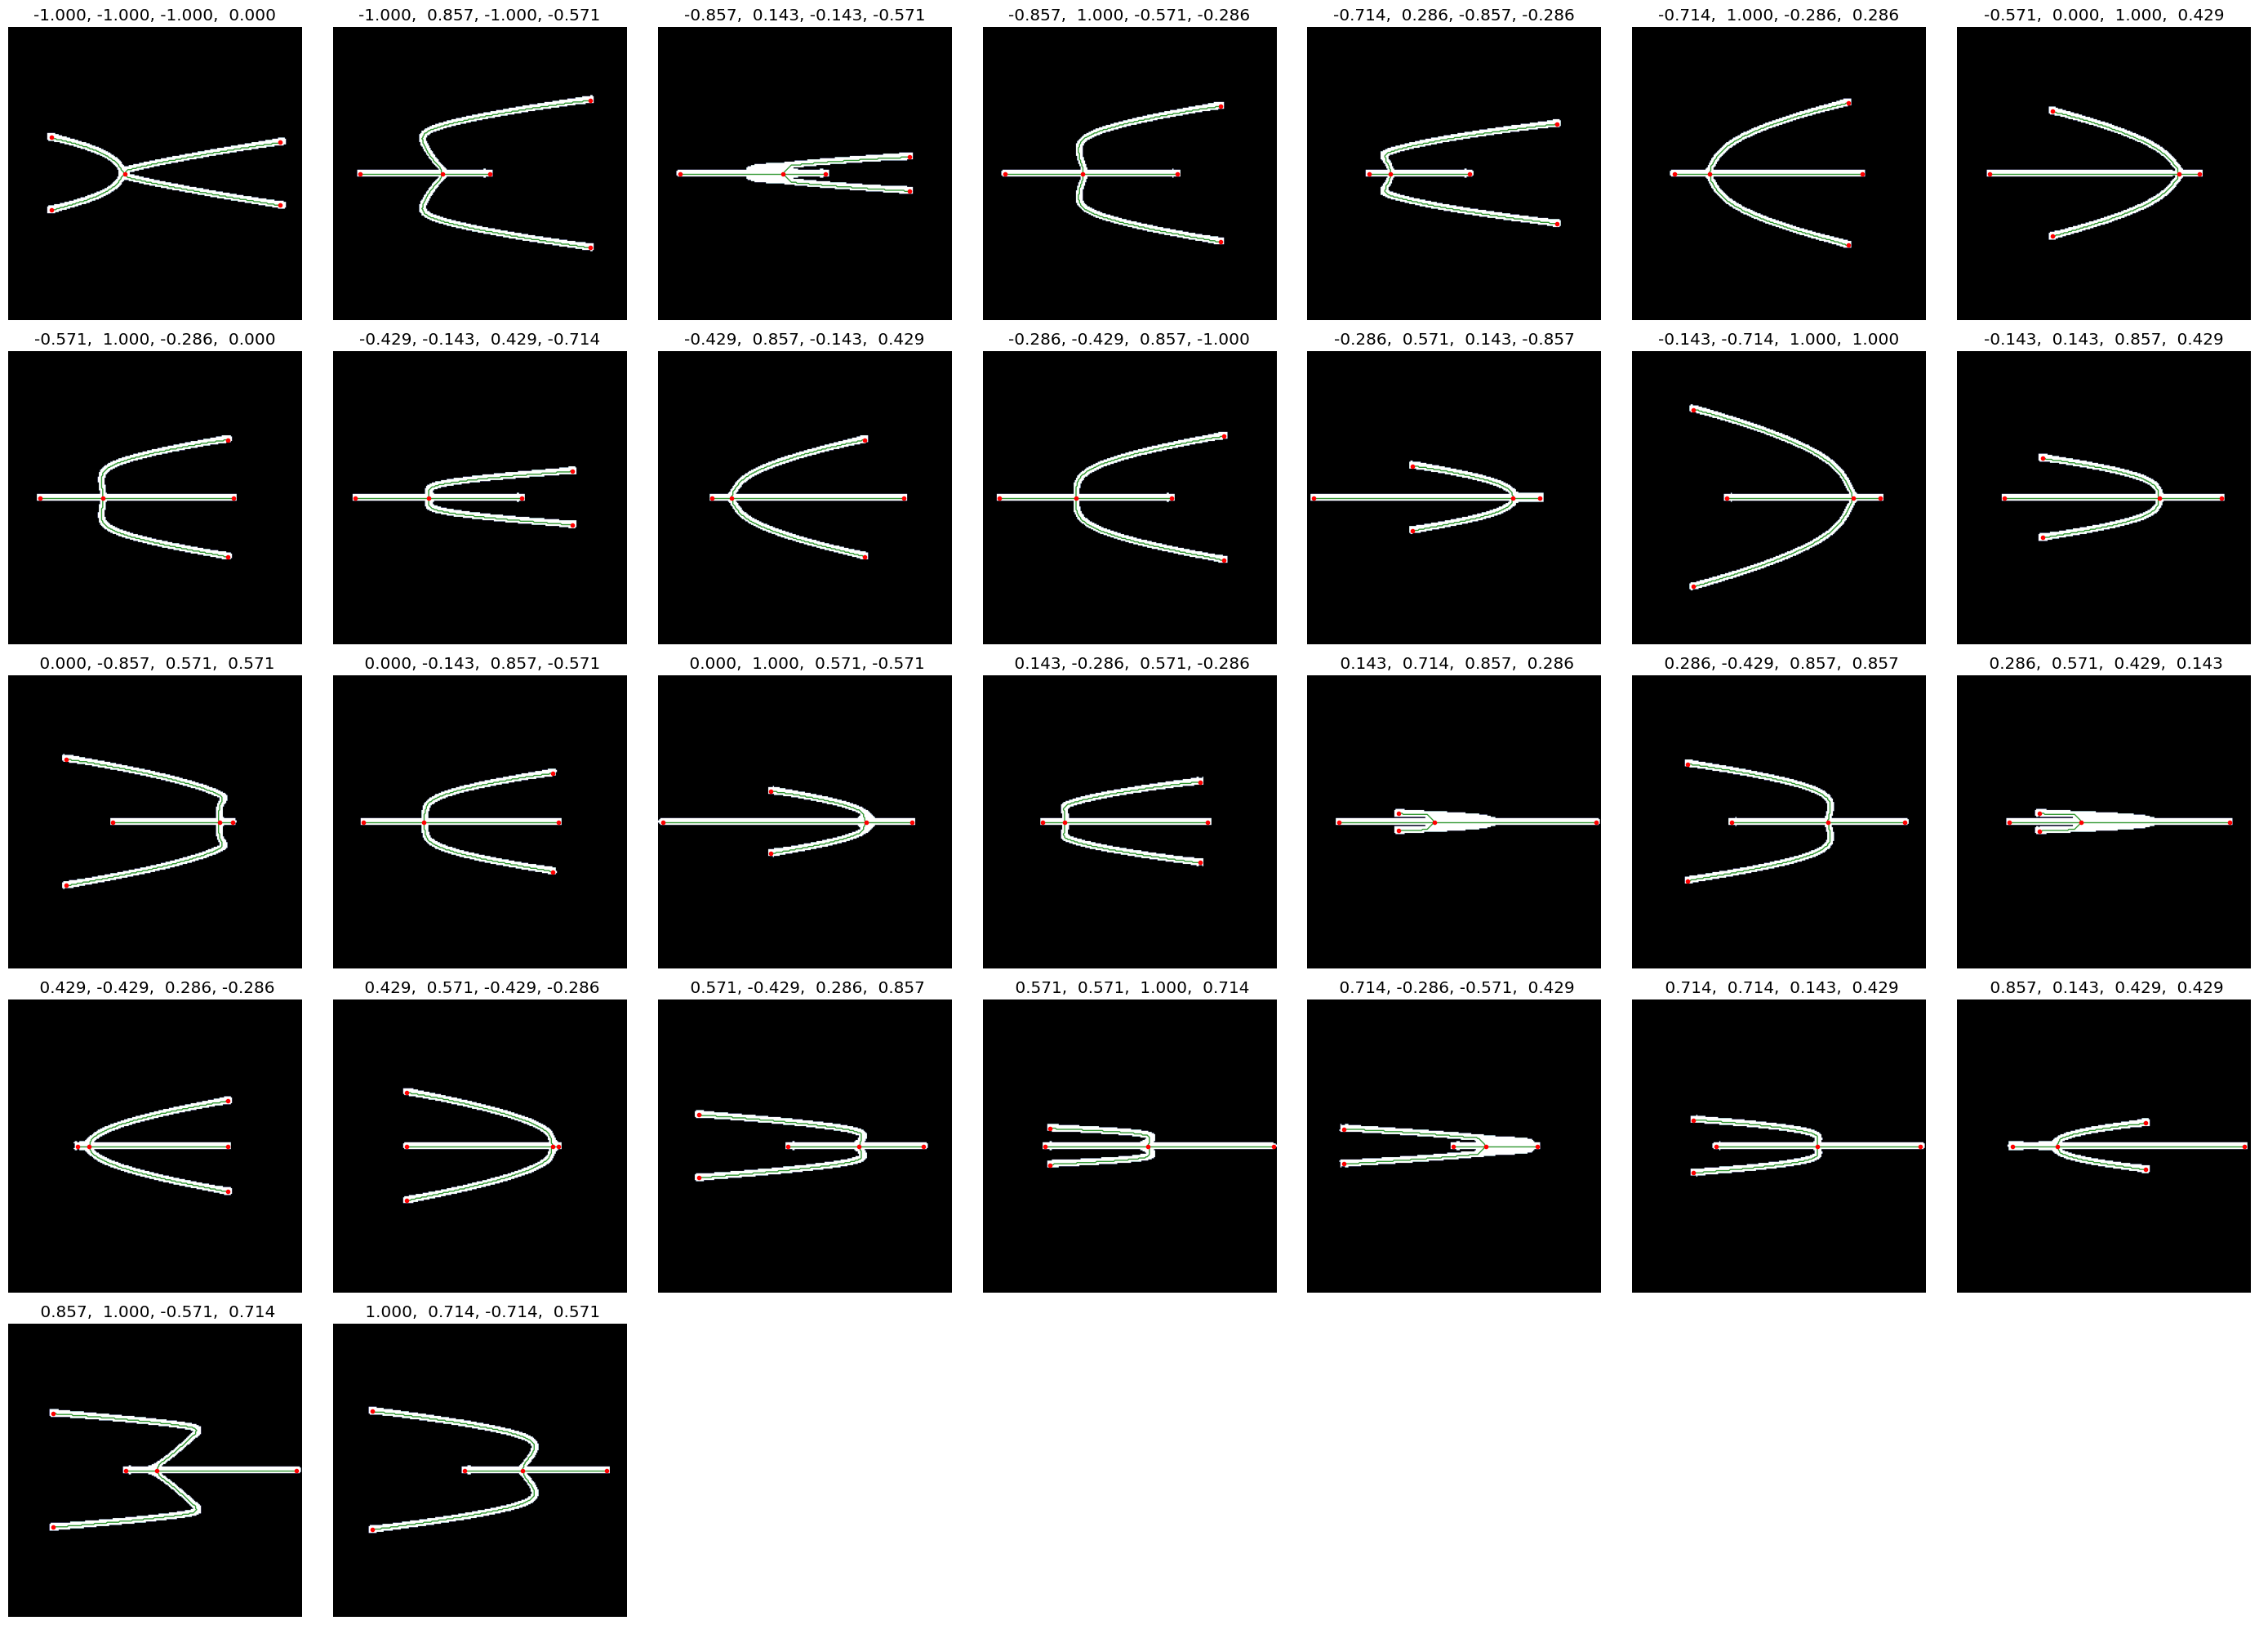

In [ ]:
draw_isomorphism_class(grouped_labels[2][::300])

There **9** coeff classes in graph class 2.

In [ ]:
coeff_class_count = lambda labels: np.unique(hash_labels(np.array(np.where(np.abs(labels) < 1e-6, 0, 1)),2,6)).size
print(coeff_class_count(grouped_labels[2]))

9


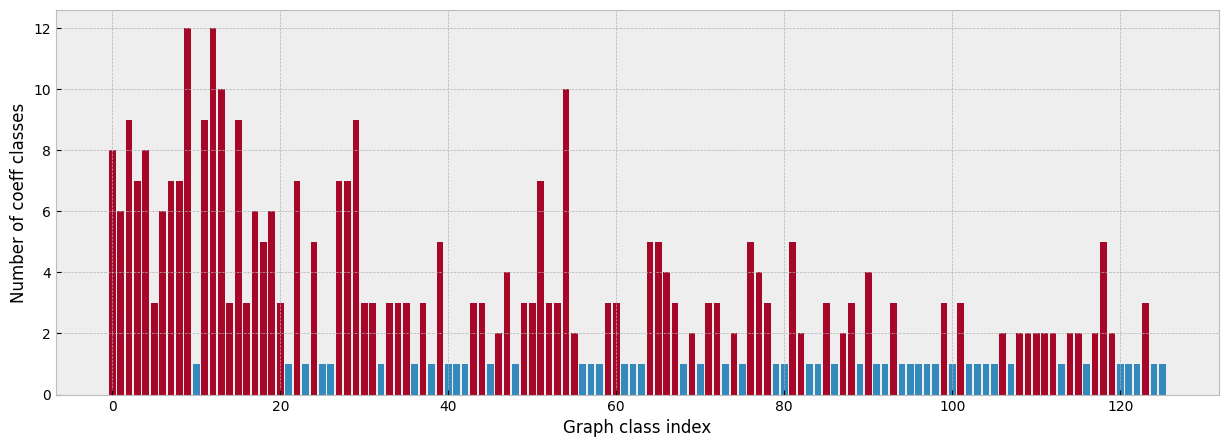

In [ ]:
graph_class_idx = []; coeff_class_cts = []
for i, labels in enumerate(grouped_labels):
    graph_class_idx.append(i)
    coeff_class_cts.append(coeff_class_count(labels))

fig, ax = plt.subplots(figsize=(15, 5))
colors = ['C0' if ct == 1 else 'C1' for ct in coeff_class_cts]
ax.bar(graph_class_idx, coeff_class_cts, color=colors)
ax.set(xlabel='Graph class index', ylabel='Number of coeff classes')
plt.show()

The failed cases (the graph classes with lowest prediction accuracies)

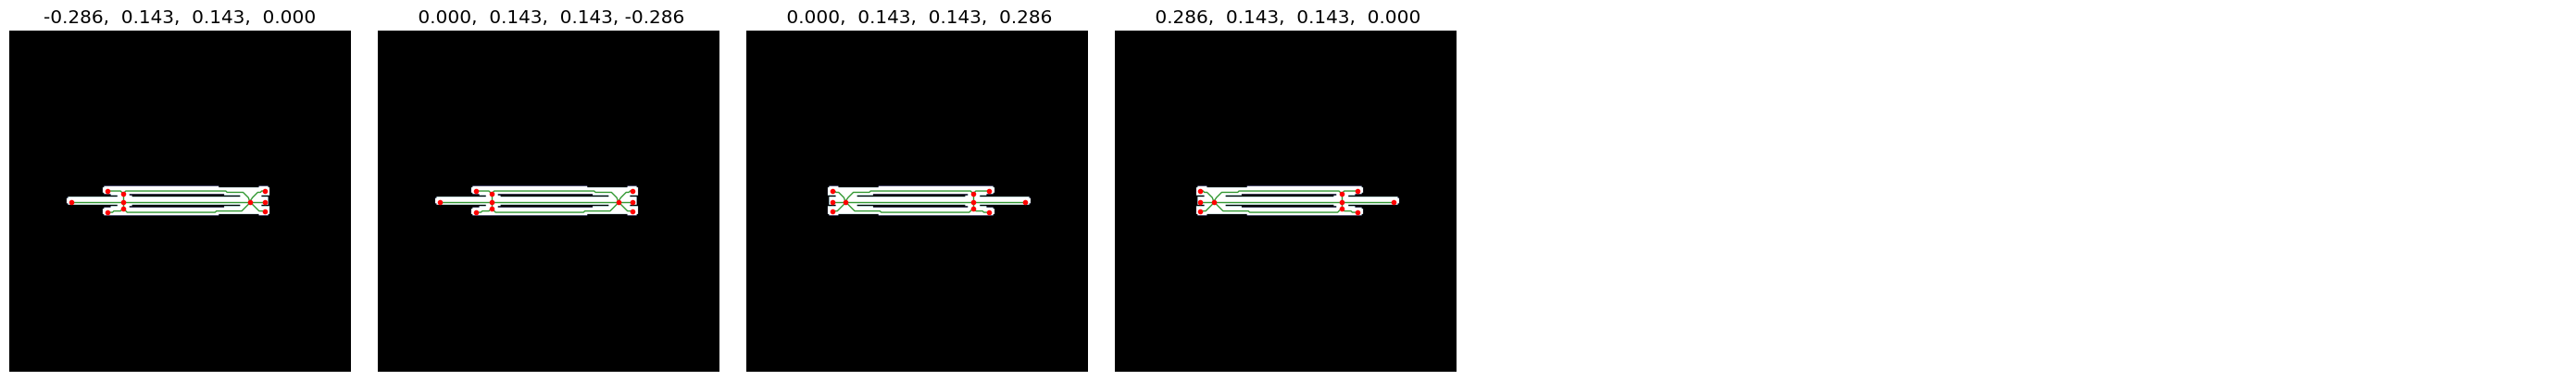

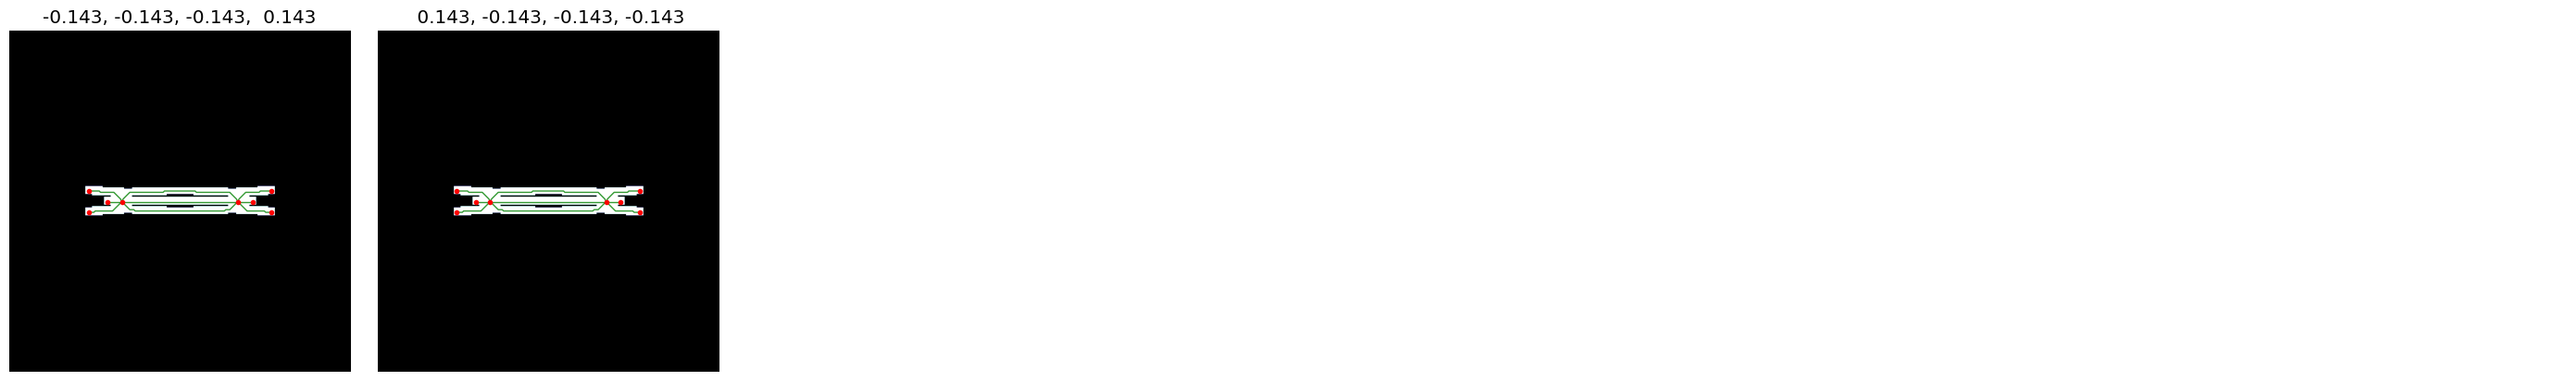

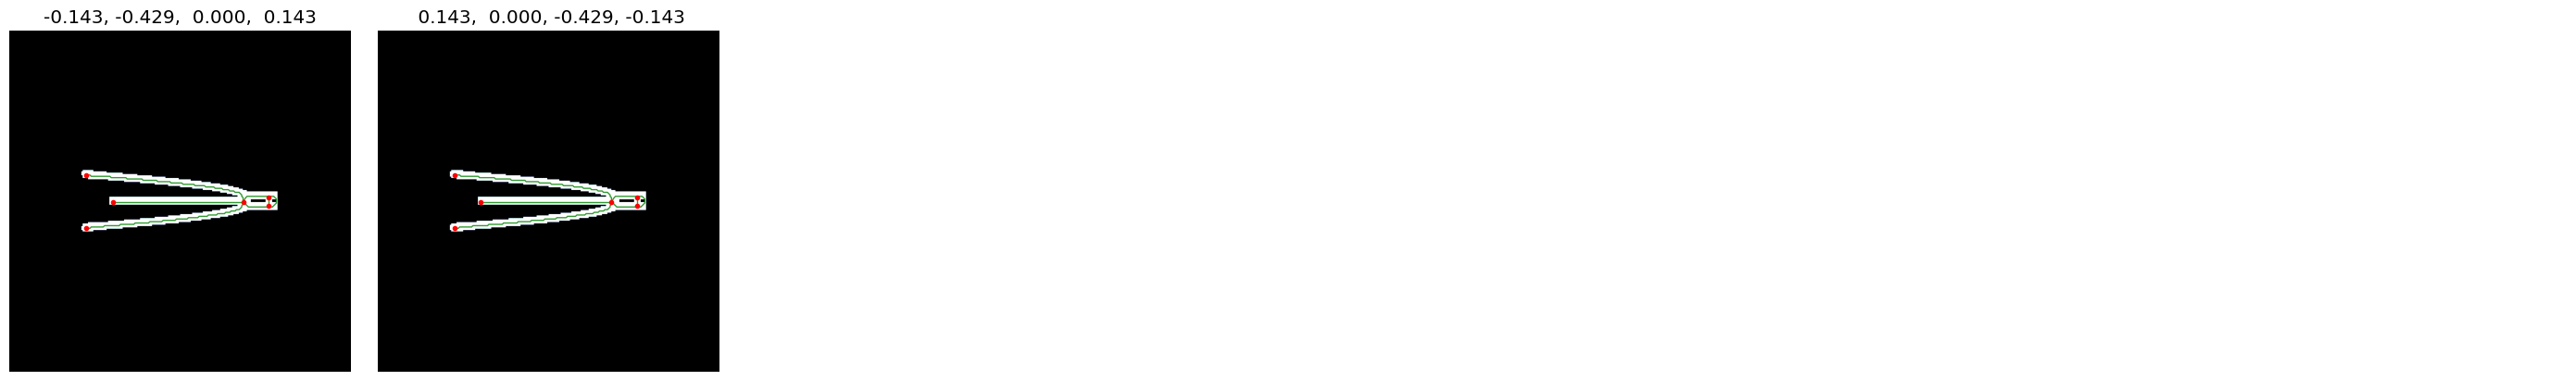

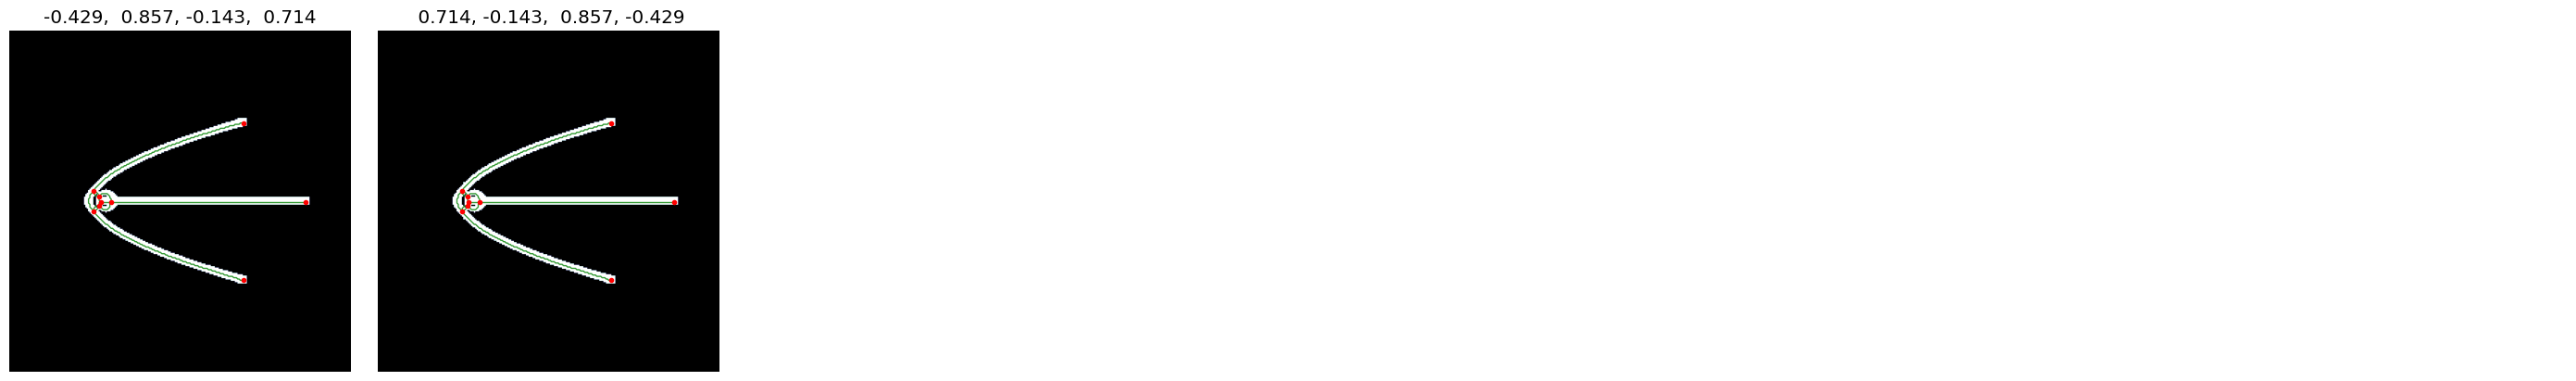

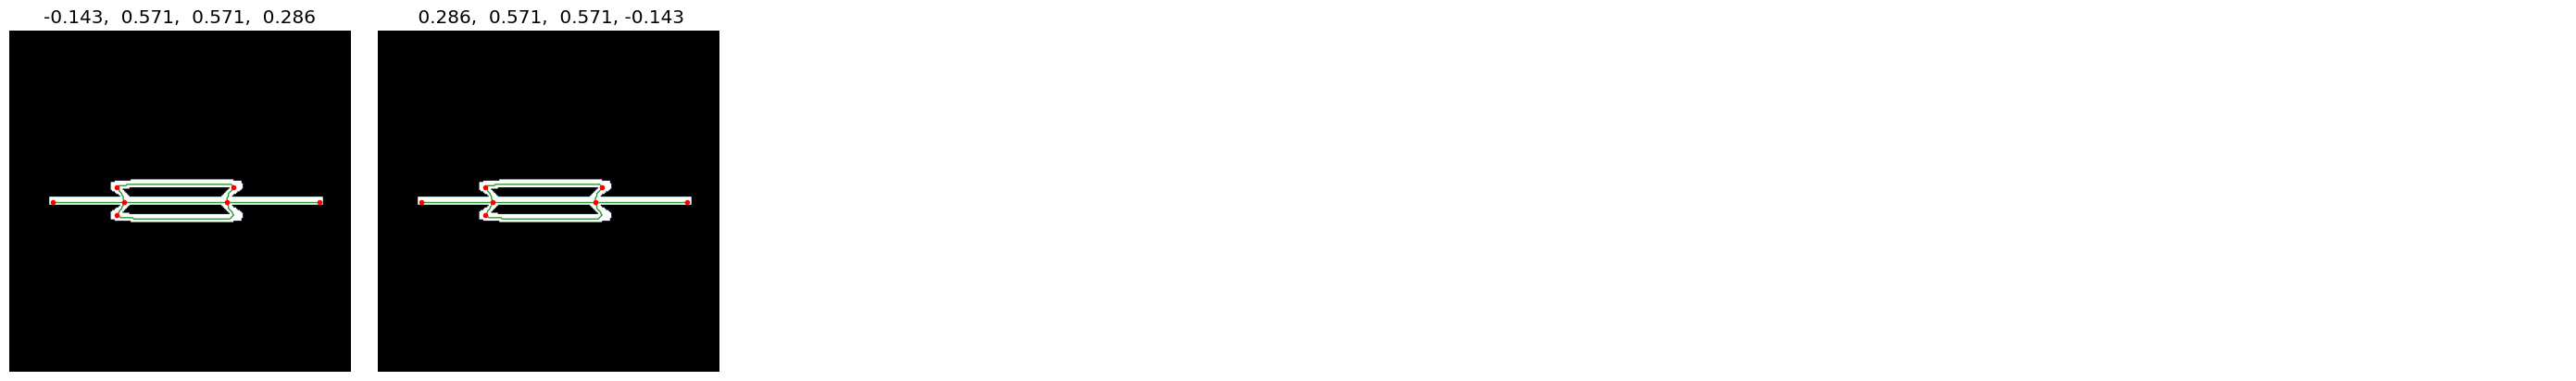

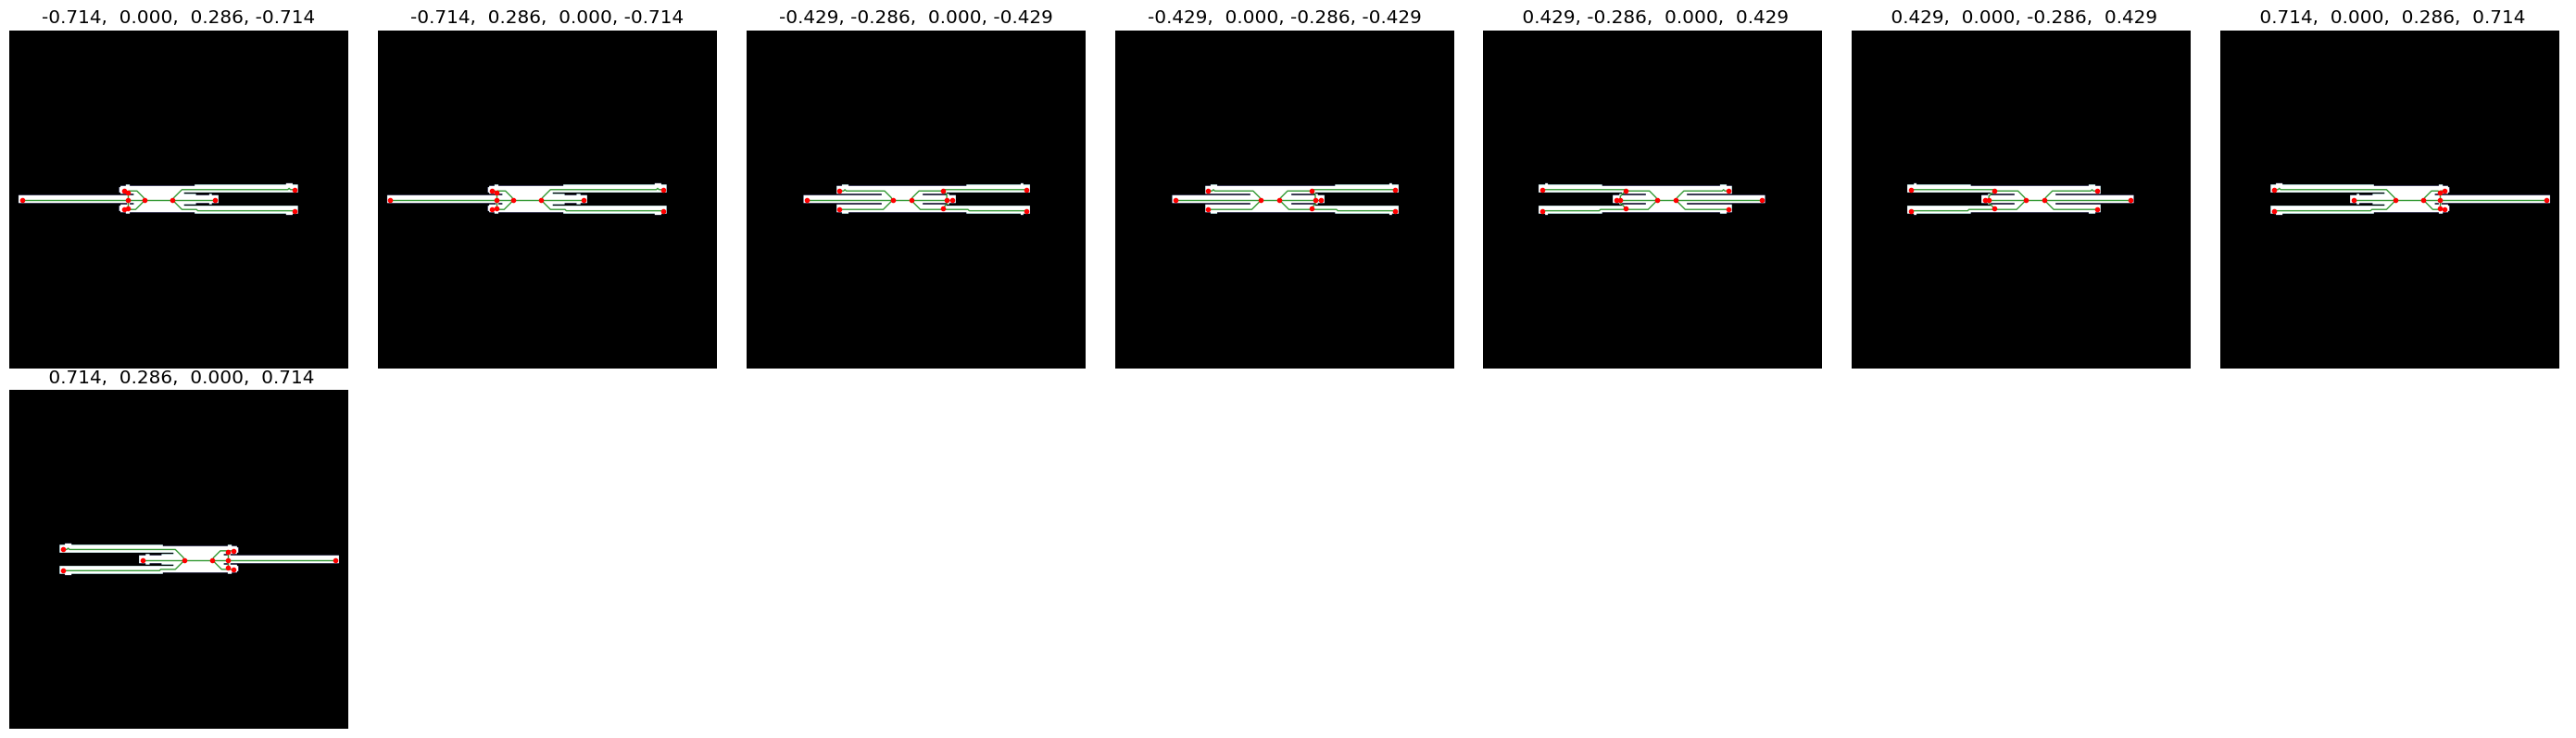

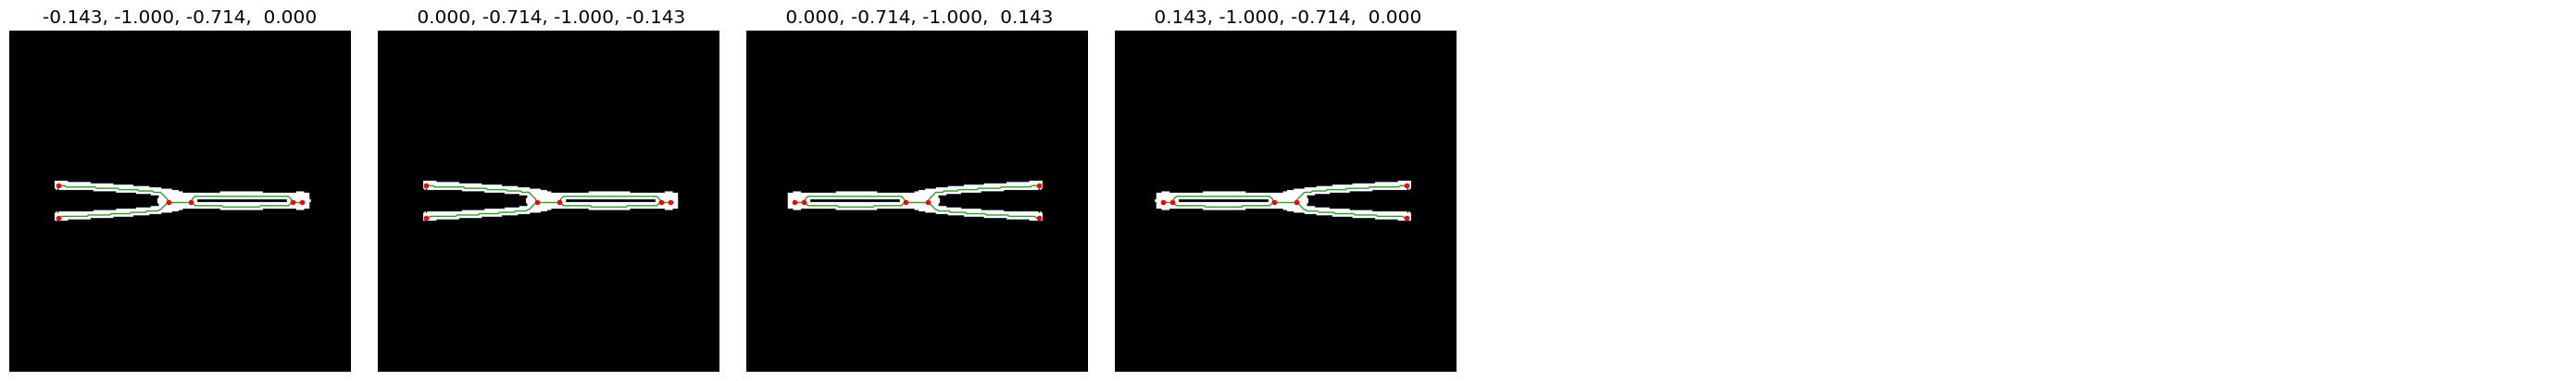

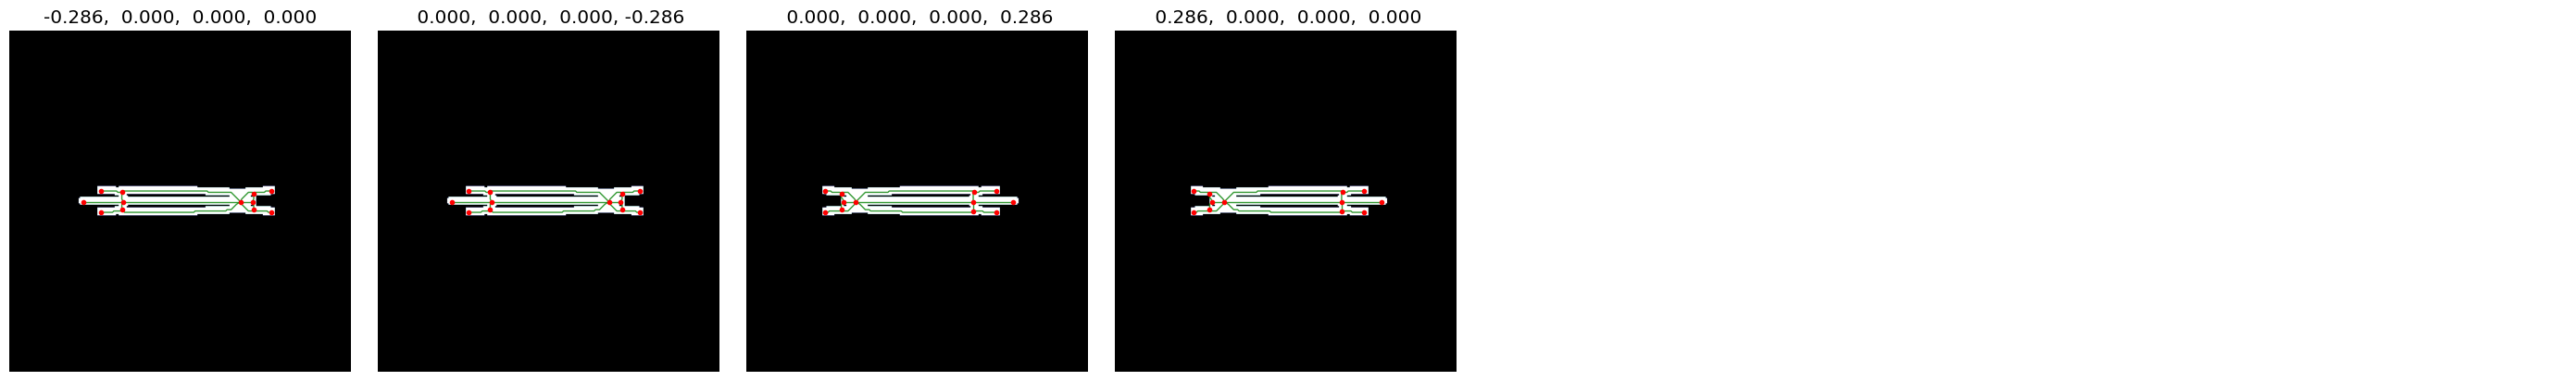

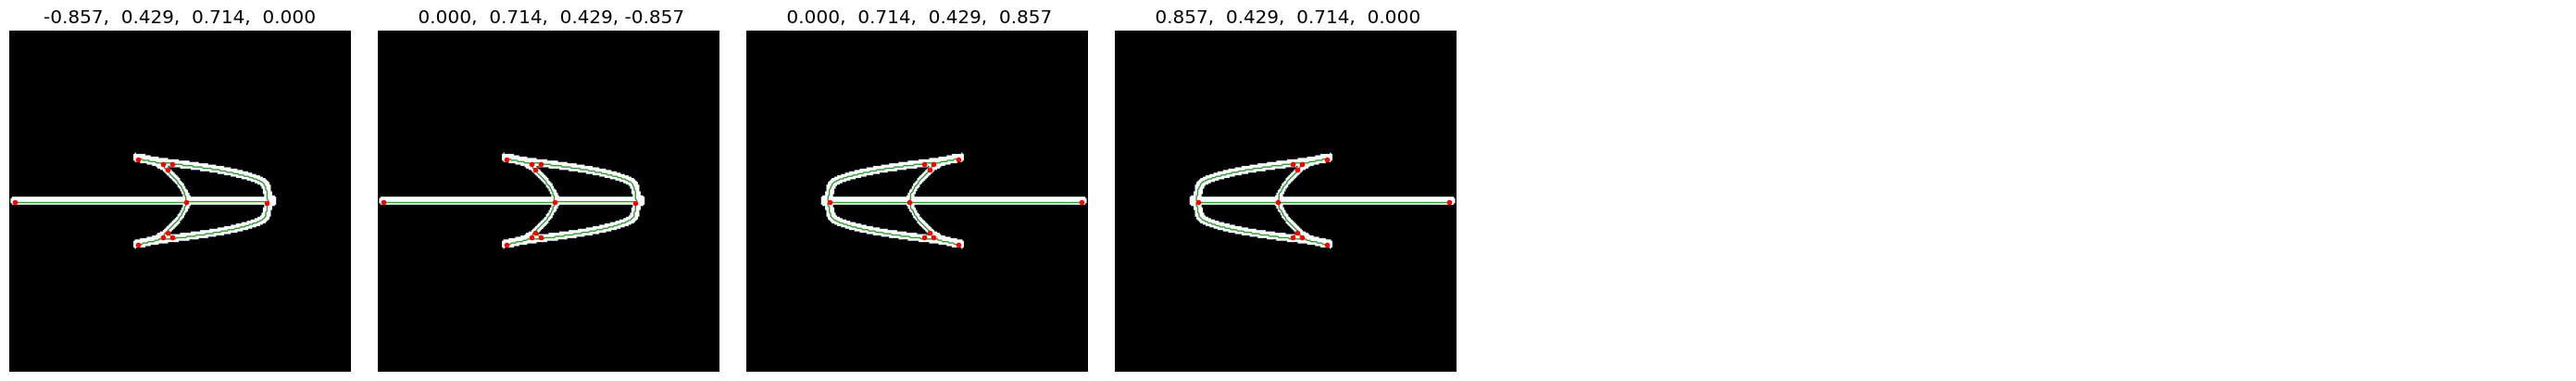

In [ ]:
for i in idx[:9]:
    draw_isomorphism_class(grouped_labels[i])

### 3.3 Predict each coeff independently

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_in = pyg_data_G_list[0].num_node_features
L_in = pyg_data_L_list[0].num_node_features
num_out = pyg_data_G_list[0].y_multi.shape[1]
gnl_mlb = GnL_multilabel(G_in, L_in, 48, 512, num_out, 10, 10, dropout=0.).to(device)
print(gnl_mlb)

GnL_multilabel(
  (afp_G): AttentiveFP(in_channels=2, node_channels=48, graph_channels=480, out_channels=480, edge_dim=1, num_layers=10, num_timesteps=2)
  (afp_L): AttentiveFP(in_channels=1, node_channels=48, graph_channels=480, out_channels=480, edge_dim=2, num_layers=10, num_timesteps=2)
  (mlp): MLP(960, 512, 512, 512, 512, 512, 512, 512, 512, 512, 4)
)


In [ ]:
gnl_mlb = train_GnL_multilabel(gnl_mlb, train_loader, val_loader, dim_out=4, epochs=10)

Epoch   1 | Train Loss: 0.10 | Train Acc: 93.70% | Train ROC: 0.97 | Train AP: 1.00
          |   Val Loss: 0.10 |   Val Acc: 92.97% |   Val ROC: 0.96 |   Val AP: 1.00
Epoch   2 | Train Loss: 0.10 | Train Acc: 93.67% | Train ROC: 0.97 | Train AP: 1.00
          |   Val Loss: 0.10 |   Val Acc: 93.01% |   Val ROC: 0.96 |   Val AP: 1.00
Epoch   3 | Train Loss: 0.10 | Train Acc: 93.69% | Train ROC: 0.97 | Train AP: 1.00
          |   Val Loss: 0.10 |   Val Acc: 93.01% |   Val ROC: 0.96 |   Val AP: 1.00
Epoch   4 | Train Loss: 0.10 | Train Acc: 93.70% | Train ROC: 0.97 | Train AP: 1.00
          |   Val Loss: 0.10 |   Val Acc: 93.07% |   Val ROC: 0.96 |   Val AP: 1.00
Epoch   5 | Train Loss: 0.10 | Train Acc: 93.71% | Train ROC: 0.97 | Train AP: 1.00
          |   Val Loss: 0.10 |   Val Acc: 93.11% |   Val ROC: 0.96 |   Val AP: 1.00
Epoch   6 | Train Loss: 0.10 | Train Acc: 93.71% | Train ROC: 0.97 | Train AP: 1.00
          |   Val Loss: 0.10 |   Val Acc: 93.05% |   Val ROC: 0.96 |   Val A

Evaluate on test dataset

In [ ]:
test_loss, test_acc, test_roc, test_ap = test_GnL_multilabel(gnl_mlb, test_loader, dim_out=4)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}% | Test ROC: {test_roc:.2f} | Test AP: {test_ap:.2f}')

Test Loss: 0.09 | Test Acc: 93.52% | Test ROC: 0.97 | Test AP: 1.00


## Appendix

The full computation graph of the `GnL` model:

<!-- <div align="center">
    <img src="./Plots/GNN/GCN_GnL_multilabel.png" width="1000">
</div> -->

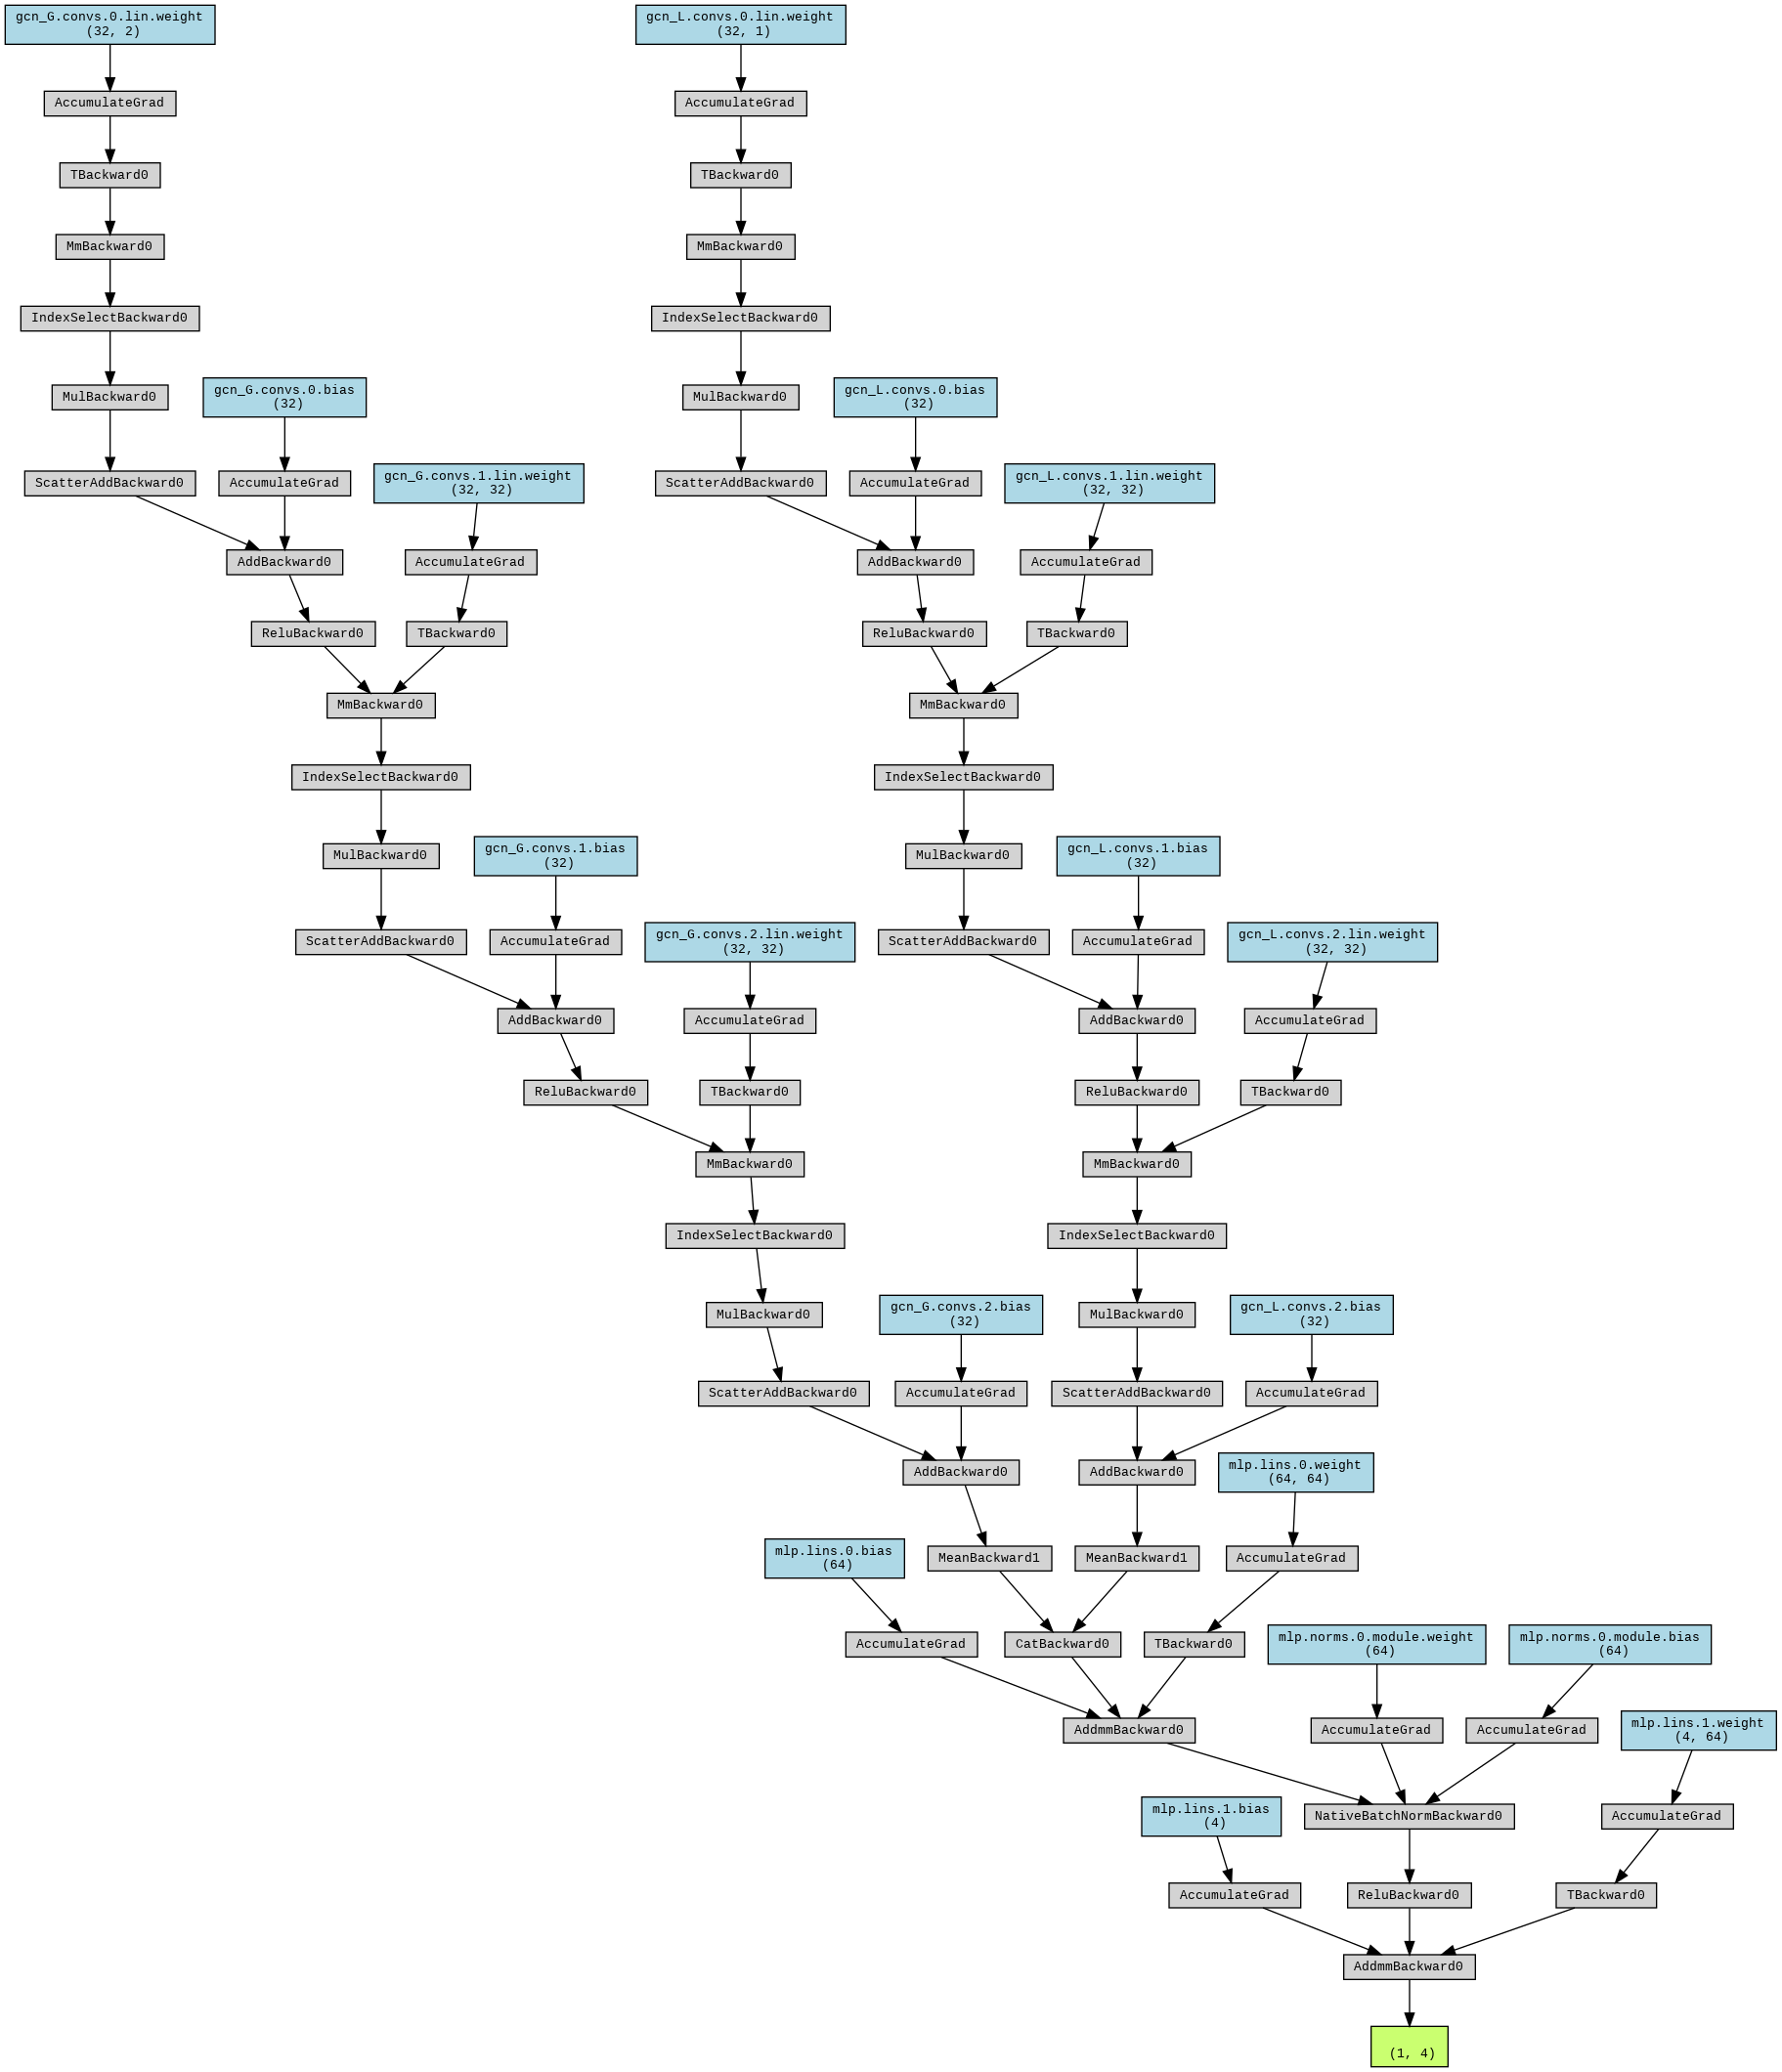

In [ ]:
display(Image(filename='./Plots/GNN/GCN_GnL_multilabel.png', width=1000))

## Discarded